# 1.Import essential packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


def drop_collinear(df, cutoff_rate):
    """checks the collinearity of each pair of features in the dataframe and drops a single feature of the 
    pair x_1, x_2, if |corr(x_1, x_2)| >= cuttof_rate"""

    corr_matrix = df.corr()
    upper_diagonal_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    collinear_columns = [column for column in upper_diagonal_matrix.columns if 
                         any(abs(upper_diagonal_matrix[column]) >= cutoff_rate)]
    new_df = df.drop(collinear_columns, axis = 1)
    return new_df


def stratified_sampling(df):
    df['oldpeak_cat'] = pd.qcut(df['oldpeak'], q = 3, labels=[1, 2, 3])
    df['thalach_cat'] = pd.qcut(df['thalach'], q = 4, labels=[1, 2, 3, 4])
    train, test = train_test_split(df, test_size=0.3, random_state=46, 
    stratify=df[['cp', 'oldpeak_cat', 'thalach_cat']])

    train = train.drop(['thalach_cat', 'oldpeak_cat'], axis=1)
    test = test.drop(['thalach_cat', 'oldpeak_cat'], axis=1)
    return train, test

def decimal_scaler(df, columns):
    """Takes a data frame and a list of columns names and normalizes each column by decimal scaling"""
    for column in columns:
        j = len(str(max(abs(df[column]))))
        df[column] = df[column] / 10**j


if __name__ ==  '__main__':
    data = pd.read_csv('heart.csv')
    train, test = stratified_sampling(data)
    train.to_csv('strat_train.csv', index = False)
    test.to_csv('strat_test.csv', index = False)


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.compose import  make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

# 2.Data exploration:

### 2.1 first we import our data

In [ ]:
bigData= pd.read_csv('heart.csv')
bigData.head()

### 2.2 check if our data hold any NULL values

In [4]:
bigData.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

### 2.3Further Understand the general structure of our data 

In [5]:
bigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [6]:
bigData.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

# 

# Parameters Information:

- age
- sex
- chest pain type (4 values) (CP)
- resting blood pressure (trestbps) 
- serum cholestoral in mg/dl (chol)
- fasting blood sugar > 120 mg/dl (fbs)
- resting electrocardiographic results (values 0,1,2) (restecg)
- maximum heart rate achieved (thalach)
- exercise induced angina (exang)
- oldpeak = ST depression induced by exercise relative to rest
- the slope of the peak exercise ST segment
- number of major vessels (0-3) colored by flourosopy
- thal: 0 = normal; 1 = fixed defect; 2 = reversable defect

In [7]:
bigData.shape

(1025, 14)

### 2.3.1 Check the descriptive statistics of the dataset (mean, distributions, etc) 

In [ ]:
print("a")

# 3.Data Cleaning:

### 3.1Check for any outliers

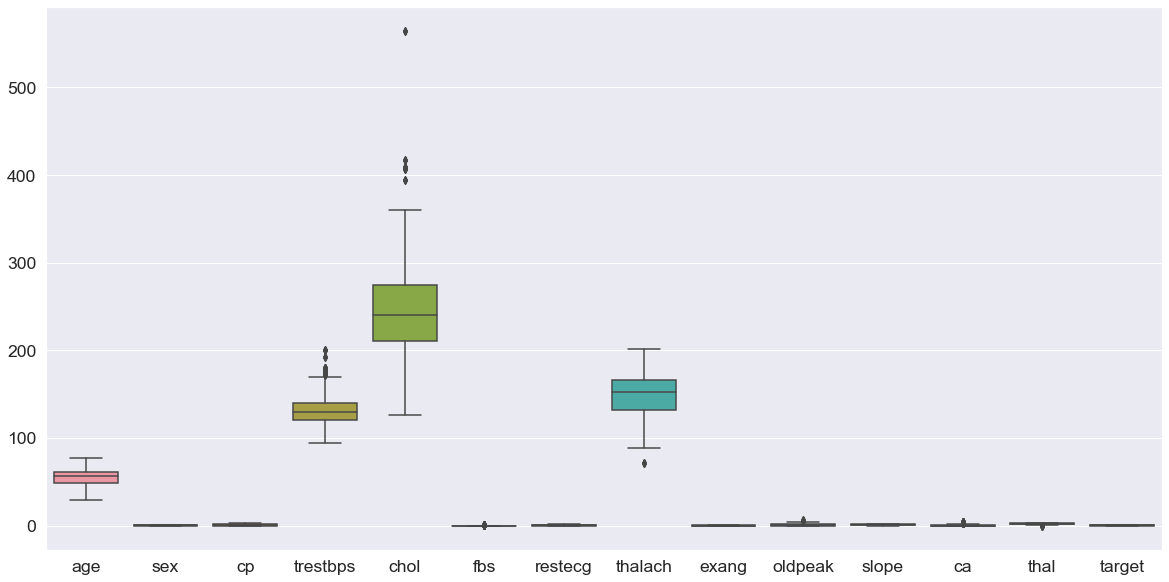

In [9]:
sns.set(style="darkgrid", palette="muted", font_scale=1.6)
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data = bigData)
plt.show()

In [10]:
continous_features = ['age','trestbps','chol','thalach','oldpeak']  
def outliers(df_out, drop = False):
    for each_feature in df_out.columns:
        feature_data = df_out[each_feature]
        Q1 = np.percentile(feature_data, 25.) # 25th percentile of the data of the given feature
        Q3 = np.percentile(feature_data, 75.) # 75th percentile of the data of the given feature
        IQR = Q3-Q1 #Interquartile Range
        outlier_step = IQR * 1.5 #That's we were talking about above
        outliers = feature_data[~((feature_data >= Q1 - outlier_step) & (feature_data <= Q3 + outlier_step))].index.tolist()  
        if not drop:
            print('For the feature {}, No of Outliers is {}'.format(each_feature, len(outliers)))
        if drop:
            bigData.drop(outliers, inplace = True, errors = 'ignore')

outliers(bigData[continous_features])

For the feature age, No of Outliers is 0
For the feature trestbps, No of Outliers is 30
For the feature chol, No of Outliers is 16
For the feature thalach, No of Outliers is 4
For the feature oldpeak, No of Outliers is 7


In [11]:
outliers(bigData[continous_features], drop=True)

#### cleaned dataset:

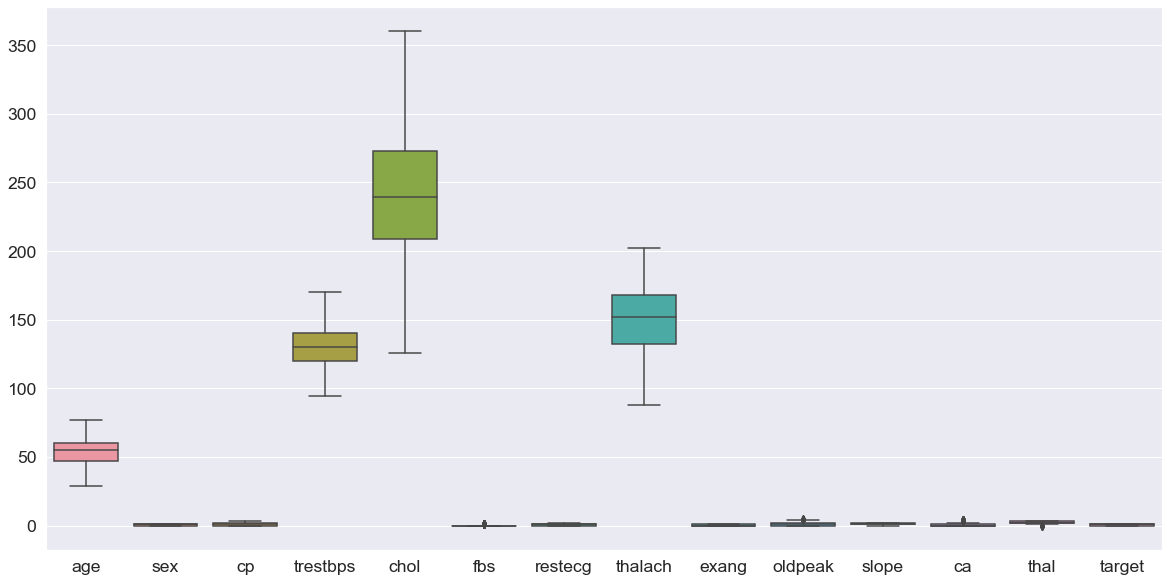

In [12]:
sns.set(style="darkgrid", palette="muted", font_scale=1.6)
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data = bigData)
plt.show()

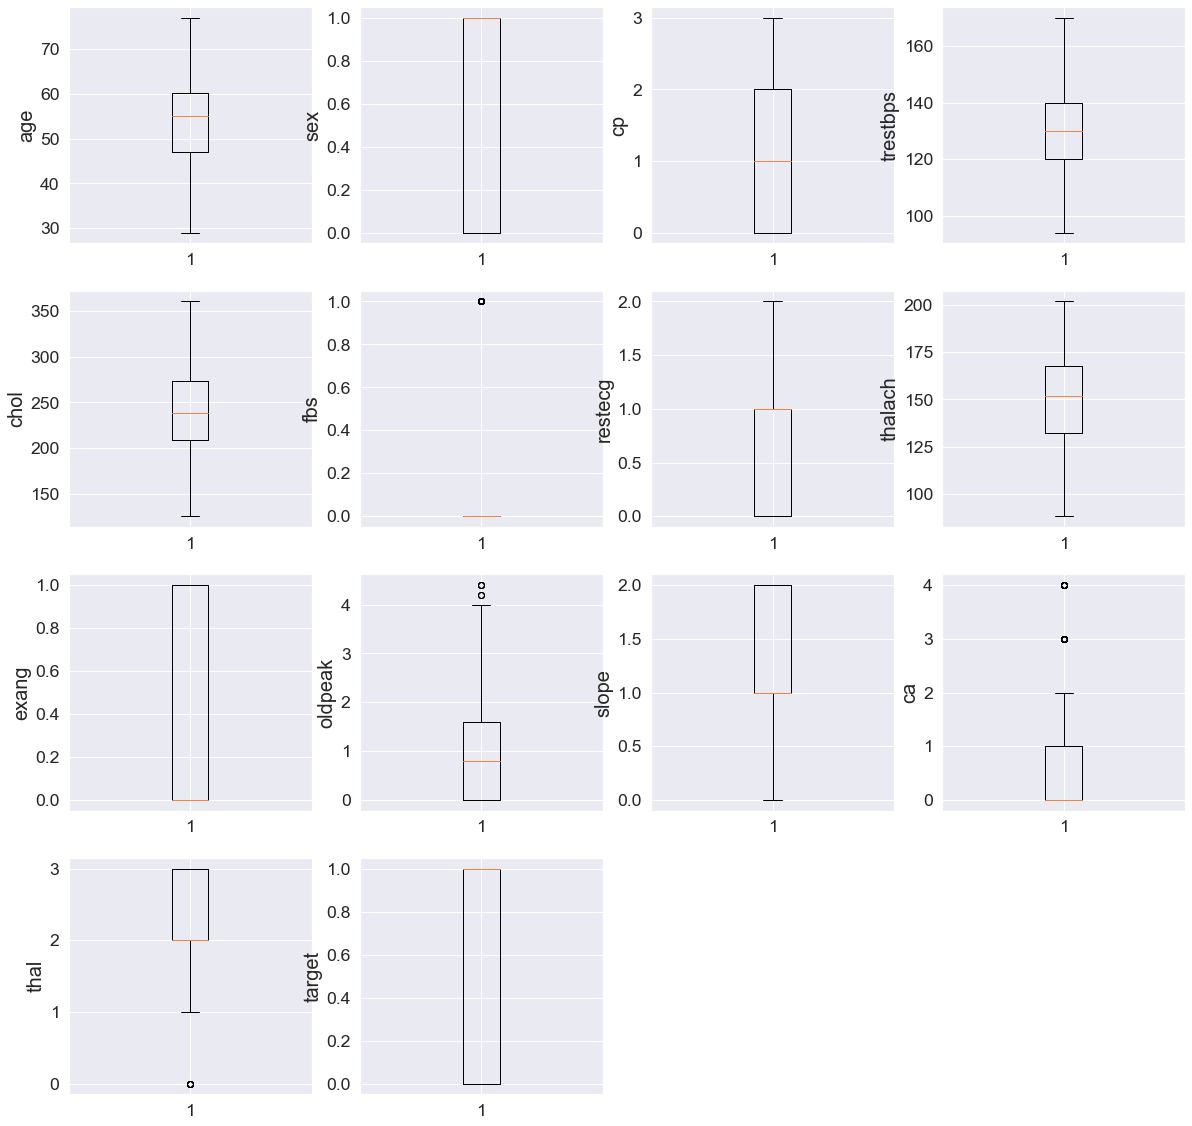

In [13]:
plt.figure(figsize=(20,20), facecolor='white')

plotnumber=1
for column in bigData.columns:
    if plotnumber<15 :    
        plt.subplot(4,4,plotnumber)  
        plt.boxplot(bigData[column])
        plt.ylabel(column,fontsize=20)
    plotnumber+=1
plt.show()

# 4. Exploratory analysis¶

In [14]:
correlation=bigData.corr()
correlation

age       sex        cp  trestbps      chol       fbs  \
age       1.000000 -0.072779 -0.065850  0.266803  0.189650  0.108528   
sex      -0.072779  1.000000 -0.084156 -0.005060 -0.118214  0.050338   
cp       -0.065850 -0.084156  1.000000  0.080177 -0.095109  0.073221   
trestbps  0.266803 -0.005060  0.080177  1.000000  0.105524  0.125341   
chol      0.189650 -0.118214 -0.095109  0.105524  1.000000  0.028783   
fbs       0.108528  0.050338  0.073221  0.125341  0.028783  1.000000   
restecg  -0.131142 -0.065811  0.069686 -0.160600 -0.123279 -0.103872   
thalach  -0.402741 -0.048660  0.302022 -0.058076 -0.045232 -0.024456   
exang     0.086087  0.180880 -0.397040 -0.006700  0.082030  0.028270   
oldpeak   0.207088  0.154633 -0.165274  0.116567  0.034817  0.010695   
slope    -0.156161 -0.061409  0.117176 -0.066118  0.003889 -0.062794   
ca        0.281349  0.158001 -0.164213  0.102915  0.080830  0.134263   
thal      0.058827  0.227441 -0.173282 -0.003034  0.087588 -0.073766   
target   -0.228869 -0.319633  0.422152 -0.104933 -0.133325 -0.037932   

           restecg   thalach     exang   oldpeak     slope        ca  \
age      -0.131142 -0.402741  0.086087  0.207088 -0.156161  0.281349   
sex      -0.065811 -0.048660  0.180880  0.154633 -0.061409  0.158001   
cp        0.069686  0.302022 -0.397040 -0.165274  0.117176 -0.164213   
trestbps -0.160600 -0.058076 -0.006700  0.116567 -0.066118  0.102915   
chol     -0.123279 -0.045232  0.082030  0.034817  0.003889  0.080830   
fbs      -0.103872 -0.024456  0.028270  0.010695 -0.062794  0.134263   
restecg   1.000000  0.091254 -0.102713 -0.042984  0.082544 -0.051126   
thalach   0.091254  1.000000 -0.394899 -0.352936  0.388459 -0.244128   
exang    -0.102713 -0.394899  1.000000  0.334418 -0.262056  0.117944   
oldpeak  -0.042984 -0.352936  0.334418  1.000000 -0.534706  0.208313   
slope     0.082544  0.388459 -0.262056 -0.534706  1.000000 -0.059881   
ca       -0.051126 -0.244128  0.117944  0.208313 -0.059881  1.000000   
thal      0.004321 -0.116665  0.199423  0.163446 -0.060322  0.131760   
target    0.155776  0.427200 -0.433572 -0.449996  0.333978 -0.379418   

              thal    target  
age       0.058827 -0.228869  
sex       0.227441 -0.319633  
cp       -0.173282  0.422152  
trestbps -0.003034 -0.104933  
chol      0.087588 -0.133325  
fbs      -0.073766 -0.037932  
restecg   0.004321  0.155776  
thalach  -0.116665  0.427200  
exang     0.199423 -0.433572  
oldpeak   0.163446 -0.449996  
slope    -0.060322  0.333978  
ca        0.131760 -0.379418  
thal      1.000000 -0.335024  
target   -0.335024  1.000000

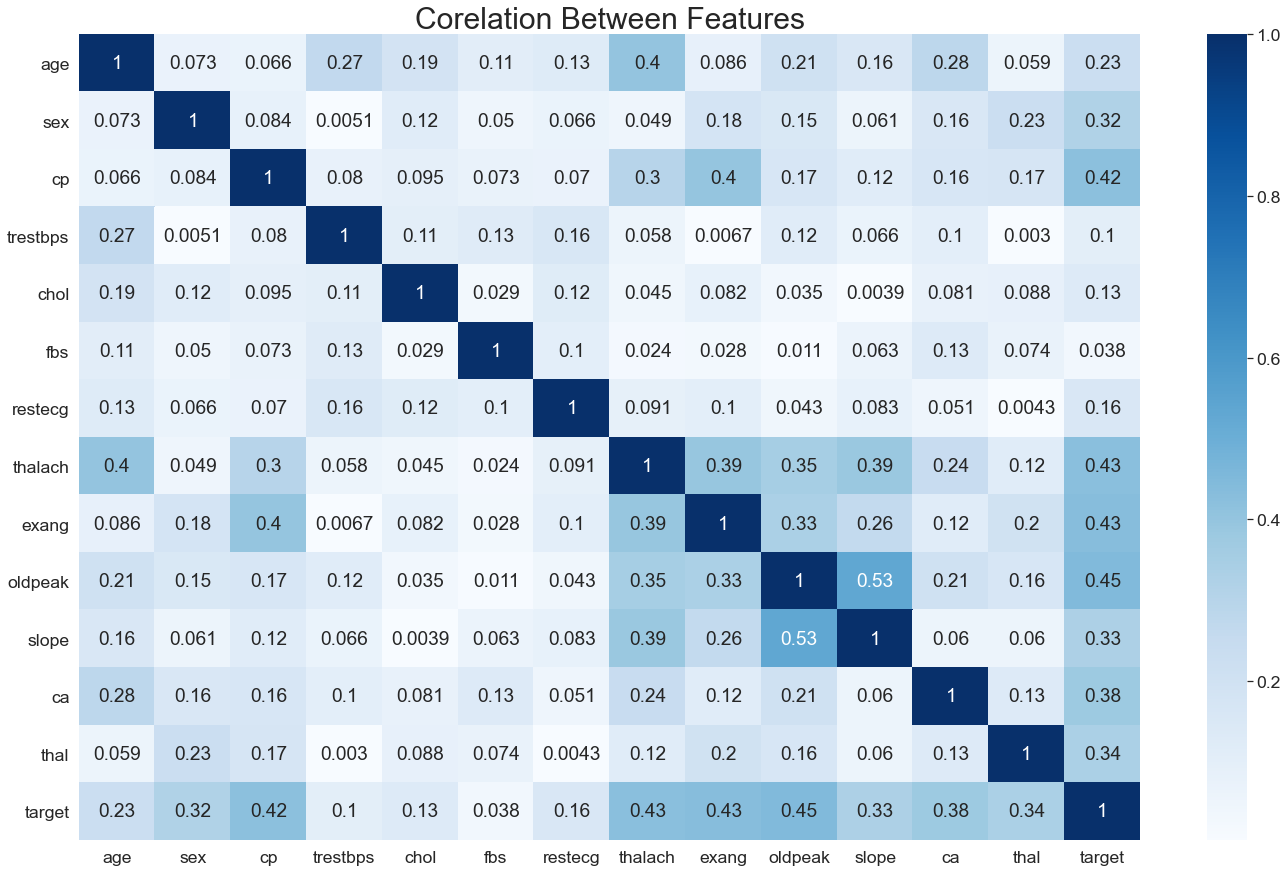

In [15]:
plt.figure(figsize=(20, 12.5))
sns.heatmap(abs(bigData.corr()), annot=True, cmap = "Blues")
plt.title('Corelation Between Features', fontsize = 30)
plt.tight_layout()
plt.show()

# 5.Data visualization

In [16]:
bigData['target'].value_counts()

1    508
0    460
Name: target, dtype: int64

In [17]:
labels=["Healthy","heart disease"]

healthy_or_not = bigData['target'].value_counts().tolist()
values = [healthy_or_not[0], healthy_or_not[1]]

fig = px.pie(values=bigData['target'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["blue","dark blue"]
             ,title="Healthy vs Heart Disease")
fig.show()

<Figure size 432x288 with 0 Axes>

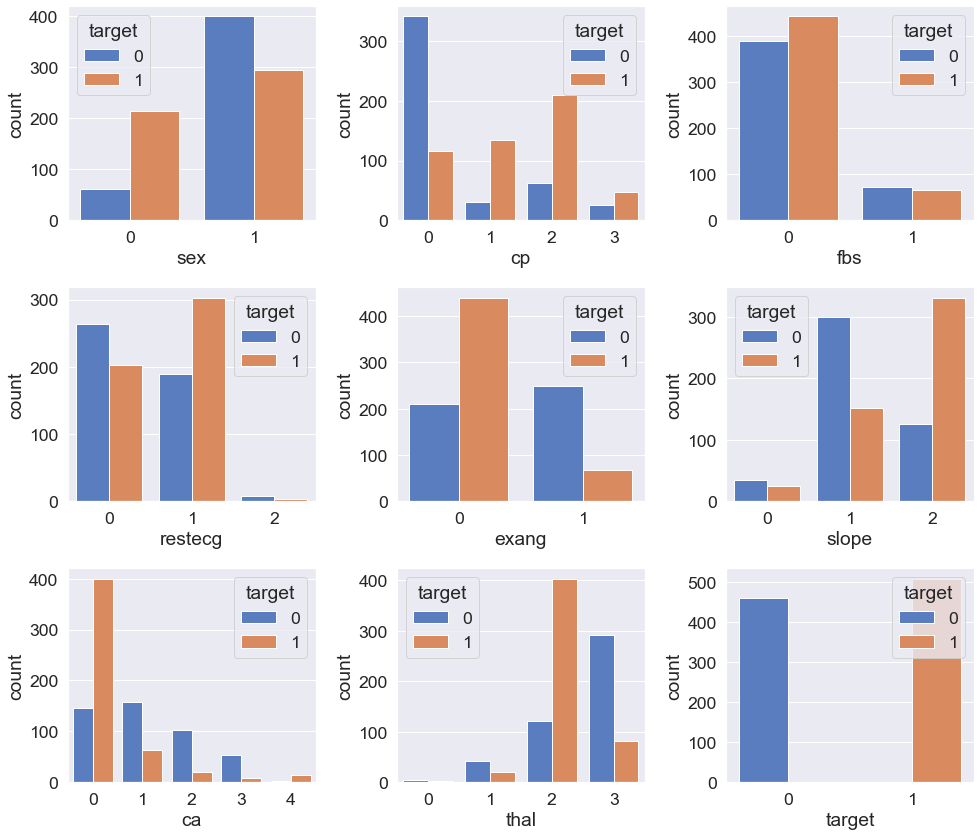

In [18]:
fig = plt.figure()
fig,ax = plt.subplots(3,3, figsize = (14,12))
sns.countplot(data=bigData, x = 'sex', hue = 'target', ax=ax[0][0])
sns.countplot(data=bigData, x = 'cp', hue = 'target', ax=ax[0][1])
sns.countplot(data=bigData, x = 'fbs', hue = 'target', ax=ax[0][2])
sns.countplot(data=bigData, x = 'restecg', hue = 'target', ax=ax[1][0])
sns.countplot(data=bigData, x = 'exang', hue = 'target', ax=ax[1][1])
sns.countplot(data=bigData, x = 'slope', hue = 'target', ax=ax[1][2])
sns.countplot(data=bigData, x = 'ca', hue = 'target', ax=ax[2][0])
sns.countplot(data=bigData, x = 'thal', hue = 'target', ax=ax[2][1])
sns.countplot(data=bigData, x = 'target', hue = 'target', ax=ax[2][2])
plt.tight_layout()
plt.show()

#### Show the count of parameters VS Target

# 6.ML Models

## 6.1 Naive bayes

In [19]:
train_data = pd.read_csv('strat_train.csv')
test_data = pd.read_csv('strat_test.csv')

In [20]:
y_train = train_data['target']
y_test = test_data['target']
train_data = train_data.drop(['target'], axis=1)
test_data = test_data.drop(['target'], axis=1)

In [21]:
train_data = drop_collinear(train_data, 0.3)
train_data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'ca', 'thal'], dtype='object')

In [22]:
num_attributes = ['age', 'trestbps', 'chol']
cat_attributes = ['cp']

num_pipeline = make_pipeline(MinMaxScaler())
cat_pipeline = make_pipeline(OneHotEncoder())

In [23]:
preprocessor = make_column_transformer(
 (num_pipeline, num_attributes),
 (cat_pipeline, cat_attributes),
)
preprocessor.fit(train_data)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age', 'trestbps', 'chol']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['cp'])])

In [24]:
train_data = preprocessor.transform(train_data)
test_data = preprocessor.transform(test_data)

In [25]:
model = MultinomialNB()
model.fit(train_data, y_train)

MultinomialNB()

In [26]:
y_train_pred = model.predict(train_data)
y_test_pred = model.predict(test_data)

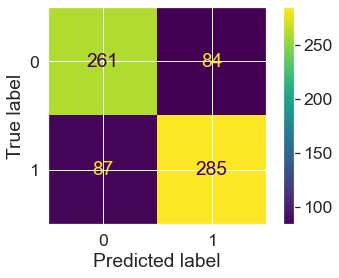

In [27]:
matrix = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(matrix).plot()

In [28]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.75      0.76      0.75       345
           1       0.77      0.77      0.77       372

    accuracy                           0.76       717
   macro avg       0.76      0.76      0.76       717
weighted avg       0.76      0.76      0.76       717



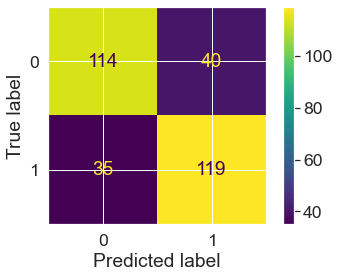

In [29]:
matrix = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(matrix).plot()

In [30]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.77      0.74      0.75       154
           1       0.75      0.77      0.76       154

    accuracy                           0.76       308
   macro avg       0.76      0.76      0.76       308
weighted avg       0.76      0.76      0.76       308



## 6.2 Support vector machine:

In [31]:
train_data2 = pd.read_csv('strat_train.csv')
test_data2 = pd.read_csv('strat_test.csv')

In [32]:
y_train2 = train_data2['target']
y_test2 = test_data2['target']
train_data2 = train_data2.drop(['target'], axis=1)
test_data2 = test_data2.drop(['target'], axis=1)

In [33]:
scaler = StandardScaler()
s_train_data2 = scaler.fit_transform(train_data2)
s_test_data2 = scaler.fit_transform(test_data2)

In [34]:
svm_model=SVC(kernel='rbf',C=2)
svm_model.fit(s_train_data2, y_train)

SVC(C=2)

In [35]:
y_train_pred2 = svm_model.predict(s_train_data2)
y_test_pred2 = svm_model.predict(s_test_data2)

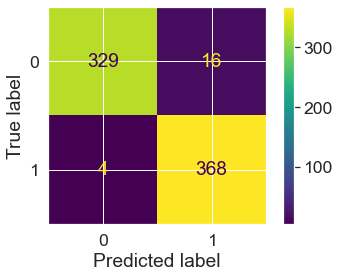

In [36]:
matrix2 = confusion_matrix(y_train, y_train_pred2)
ConfusionMatrixDisplay(matrix2).plot()

In [37]:
print(classification_report(y_train, y_train_pred2))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       345
           1       0.96      0.99      0.97       372

    accuracy                           0.97       717
   macro avg       0.97      0.97      0.97       717
weighted avg       0.97      0.97      0.97       717



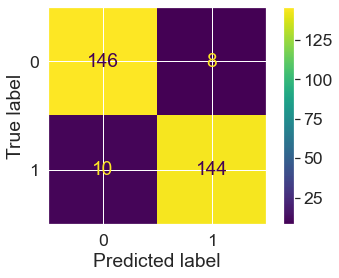

In [38]:
matrix3 = confusion_matrix(y_test, y_test_pred2)
ConfusionMatrixDisplay(matrix3).plot()

In [39]:
print(classification_report(y_test, y_test_pred2))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       154
           1       0.95      0.94      0.94       154

    accuracy                           0.94       308
   macro avg       0.94      0.94      0.94       308
weighted avg       0.94      0.94      0.94       308

